<a href="https://colab.research.google.com/github/KoeusIss/holbertonschool-machine_learning/blob/main/supervised_learning/0x0E-time_series/forecast_btc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting - Forecast Bitcoin


## Setup

In [1]:
# Connect with Google drive
# -----------------------------------------------------------------------------

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# Dependencies
# -----------------------------------------------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
import seaborn as sn

mpl.rcParams['figure.figsize'] = (12, 8)

In [3]:
# Universal constant
# -----------------------------------------------------------------------------

BATCH_SIZE = 64
MAX_EPOCHS = 20
STEPS_PER_EPOCH = 1000
VALIDATION_STEPS = 100
INUPT_WIDTH = 24
LABEL_WIDTH = 1
STRIDE_WIDTH = 1
BUFFER_SIZE = 10000

# PS: Try to provide and fork dataset from this links
# https://drive.google.com/file/d/1-2qi4aEYeMuvESgPemzWUgRhwZwmMOE8/view
# https://drive.google.com/file/d/1-1k5W0hhJPCt7Kaxrw6ECsYcWxCiMdt7/view

BITSTAMP_CSV = '/content/gdrive/MyDrive/Datasets/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv'
COINBASE_CSV = '/content/gdrive/MyDrive/Datasets/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv'

In [4]:
# Extract dataframe from csv
# -----------------------------------------------------------------------------

bitstamp_df = pd.read_csv(BITSTAMP_CSV)
coinbase_df = pd.read_csv(COINBASE_CSV)

## Data preprocessing
We need to check the percentage of missing value per column, try to visualize dataframe. In addition the dataframe is windowed per 60 second so we need to recast for need by windowing hourly

In [5]:
bitstamp_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Timestamp,4363457.0,1.456469e+09,7.573296e+07,1.325318e+09,1.390770e+09,1.456610e+09,1.522062e+09,1.587514e+09
Open,3126480.0,3.674656e+03,3.935578e+03,3.800000e+00,4.100000e+02,1.175140e+03,6.931175e+03,1.966576e+04
High,3126480.0,3.677366e+03,3.939077e+03,3.800000e+00,4.102400e+02,1.175770e+03,6.935780e+03,1.966600e+04
Low,3126480.0,3.671730e+03,3.931713e+03,1.500000e+00,4.098300e+02,1.174825e+03,6.926790e+03,1.964996e+04
Close,3126480.0,3.674595e+03,3.935490e+03,1.500000e+00,4.100000e+02,1.175140e+03,6.931225e+03,1.966575e+04
Volume_(BTC),3126480.0,9.855040e+00,3.229272e+01,0.000000e+00,3.988120e-01,1.990000e+00,7.639098e+00,5.853852e+03
Volume_(Currency),3126480.0,2.884459e+04,1.010277e+05,0.000000e+00,3.503759e+02,2.620491e+03,1.760057e+04,7.569437e+06
Weighted_Price,3126480.0,3.674570e+03,3.935458e+03,3.800000e+00,4.099998e+02,1.175200e+03,6.931180e+03,1.966330e+04


In [6]:
# There is a big difference between the count of timestamp (raws) and the available value per column
bitstamp_df.isna().sum()

Timestamp                  0
Open                 1236977
High                 1236977
Low                  1236977
Close                1236977
Volume_(BTC)         1236977
Volume_(Currency)    1236977
Weighted_Price       1236977
dtype: int64

In [7]:
# In order to handle this missing value we use teh Forward Filling method in order to cast this missing value
# I find this resource on Kaggle https://www.kaggle.com/juejuewang/handle-missing-values-in-time-series-for-beginners
df = bitstamp_df.ffill()
df.isna().sum()

Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [8]:
# let's drop the Timestamp column
date_time = pd.to_datetime(df.pop('Timestamp'), unit='s')

In [9]:
# Convert out dataframe to be hourly windowed instead of minutes with a shift by 8 row
df = df[8::60]
date_time = date_time[8::60]

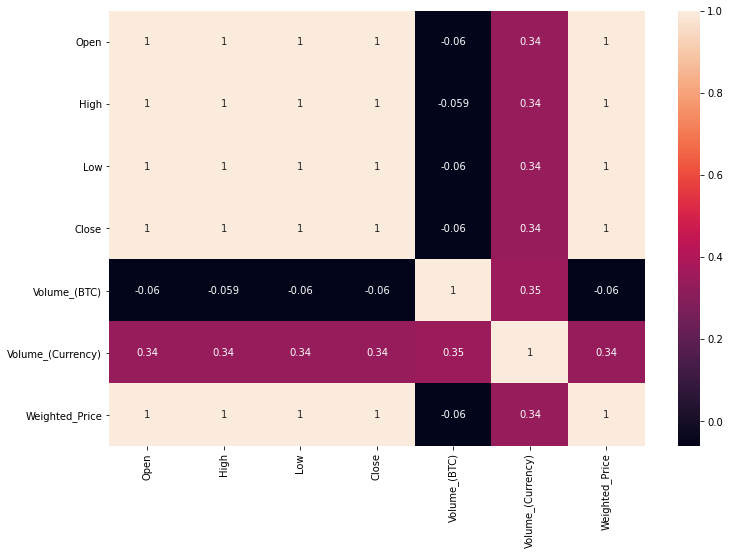

In [10]:
# Data correlation
# -----------------------------------------------------------------------------
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sn.heatmap(correlation_matrix, annot=True)
plt.show()

**Observation**
* There are a fully correlated Features which make working of the full features a redundant process

In [11]:
# Droping none relevant features
df.drop(['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)

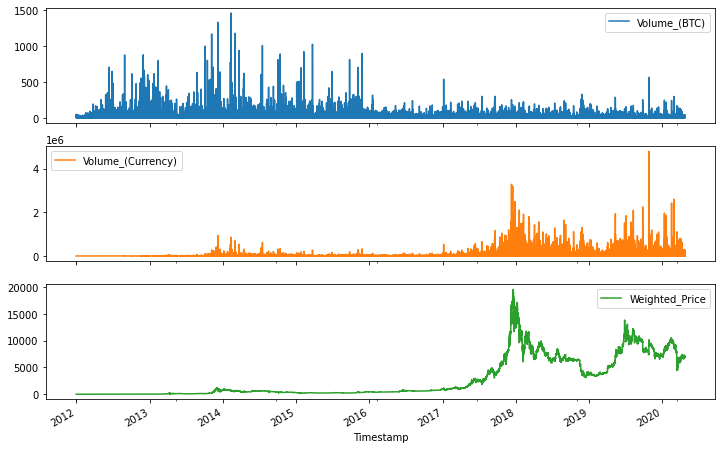

In [12]:
# Visualizing data
# -----------------------------------------------------------------------------

plot_cols = df.columns.to_list()
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


In [13]:
# Split data
# -----------------------------------------------------------------------------

n = len(df)
train_split = int(n * 0.8)

train_df = df[:train_split]
valid_df = df[train_split:]

In [14]:
# Normalization
# -----------------------------------------------------------------------------

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
valid_df = (valid_df - train_mean) / train_std

In [15]:
# Split to window
# -----------------------------------------------------------------------------

def split_window(dataframe):
  input_slice = slice(0, INUPT_WIDTH)
  labels_slice = slice(INUPT_WIDTH, None)

  inputs = dataframe[:, input_slice, :]
  labels = dataframe[:, labels_slice, :]

  labels = labels[:, :, -1:]

  inputs.set_shape([None, INUPT_WIDTH, None])
  labels.set_shape([None, LABEL_WIDTH, None])

  return inputs, labels

In [16]:
# Build datasets
# -----------------------------------------------------------------------------

def make_dataset(data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=INUPT_WIDTH + LABEL_WIDTH,
      sequence_stride=1,
      shuffle=True,
      batch_size=BATCH_SIZE
  )


  ds = ds.map(split_window)

  return ds

In [17]:
# Create train and validation datasets

train_ds = make_dataset(train_df)
valid_ds = make_dataset(valid_df)

In [18]:
# Compile and fit model
# -----------------------------------------------------------------------------
def compile_and_fit(model, train_ds, valid_ds, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience,
    mode='min'
  )

  model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
  )

  history = model.fit(
    train_ds,
    epochs=MAX_EPOCHS,
    validation_data=valid_ds,
    callbacks=[early_stopping]
  )
  return history

In [19]:
# Build RNN module using LSTM Gate

lstm_model = K.models.Sequential([
    K.layers.LSTM(64, return_sequences=False),
    K.layers.Dense(units=1)
])

In [20]:
# Train model

history = compile_and_fit(lstm_model, train_ds, valid_ds)

Epoch 1/20
909/909 [==============================] - 12s 9ms/step - loss: 0.0487 - mean_absolute_error: 0.0652 - val_loss: 0.0014 - val_mean_absolute_error: 0.0219
Epoch 2/20
909/909 [==============================] - 7s 8ms/step - loss: 8.7686e-04 - mean_absolute_error: 0.0121 - val_loss: 0.0030 - val_mean_absolute_error: 0.0450
Epoch 3/20
909/909 [==============================] - 7s 8ms/step - loss: 6.2861e-04 - mean_absolute_error: 0.0107 - val_loss: 0.0025 - val_mean_absolute_error: 0.0418


In [21]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17408     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


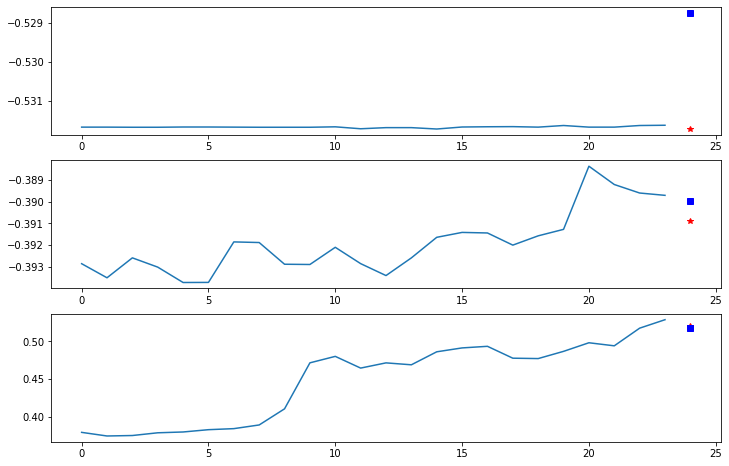

In [22]:
# Plotting prediction
# -----------------------------------------------------------------------------

for b, (x, y) in enumerate(train_ds.take(3)):
  plt.subplot(3, 1, b+1)
  plt.plot(list(range(24)), x[b, :, -1])
  plt.plot(24, y[b].numpy(), 'r*')
  plt.plot(24, lstm_model.predict(x)[b], 'bs')